In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import splitfolders
from random import randrange
from skimage import exposure
from skimage.exposure import match_histograms

#### Histogram matching of templates

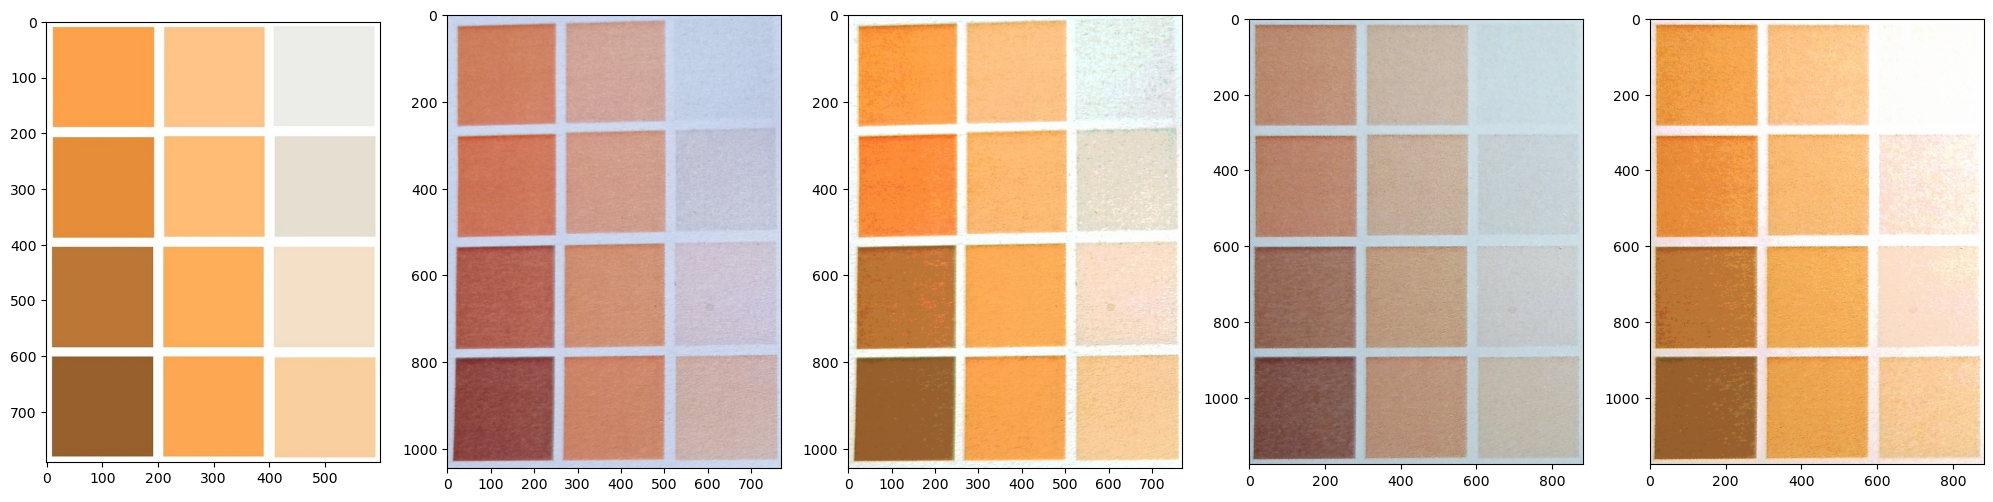

In [ ]:
template = cv2.imread("E:/project_final/t.jpg")
sun = cv2.imread("E:/project_final/natural_template.jpg") #load image of a template in natural light
bulb = cv2.imread("E:/project_final/artificial_template.jpg") #load image of a template in artificial light
sun_matched = match_histograms(sun, template, channel_axis=-1) #histogram matching of template in natural light with digital template
bulb_matched = match_histograms(bulb, template, channel_axis=-1) #histogram matching of template in artificial light with digital template

#show templates: digital, artificial light, matched artificial light, natural light, matched natural light
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,15))

ax[0].imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(bulb, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(bulb_matched, cv2.COLOR_BGR2RGB))
ax[3].imshow(cv2.cvtColor(sun, cv2.COLOR_BGR2RGB))
ax[4].imshow(cv2.cvtColor(sun_matched, cv2.COLOR_BGR2RGB))
plt.show()

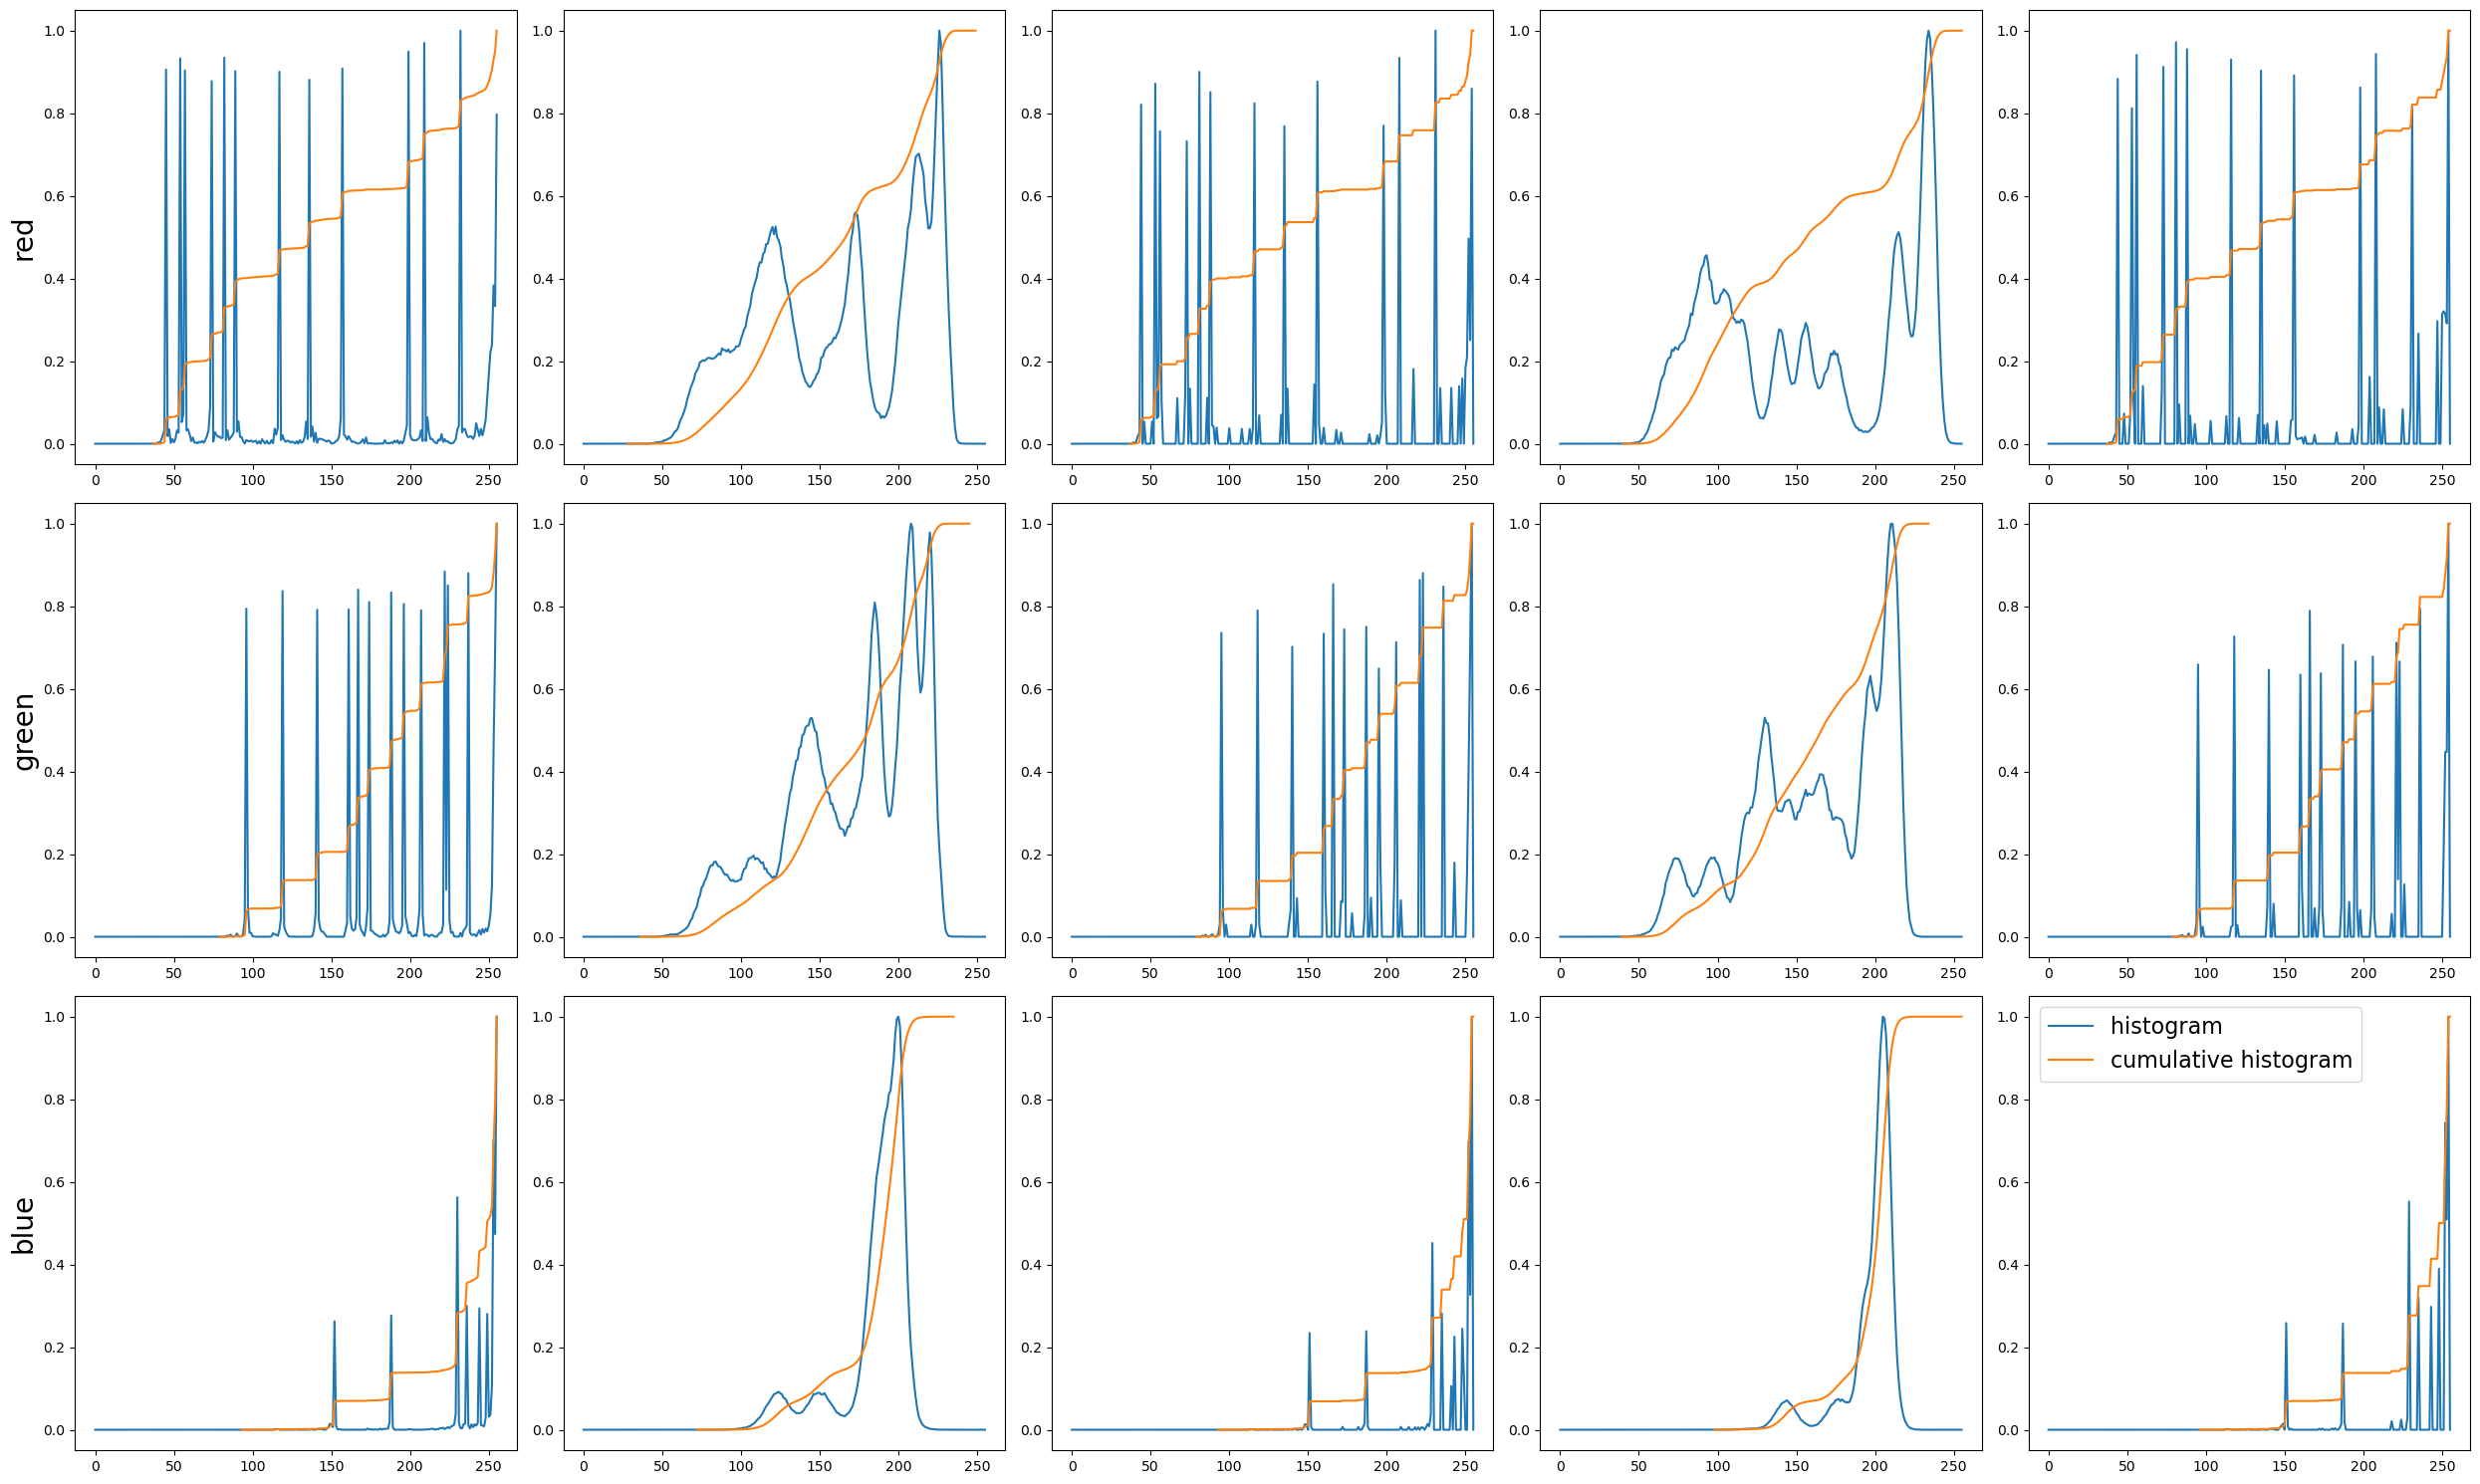

In [6]:
#show R,G,B histograms for templates: digital, artificial light, matched artificial light, natural light, matched natural light

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25,15))

for i, img in enumerate((template, sun, sun_matched, bulb, bulb_matched)):
    for c, c_color in enumerate(('red', 'green', 'blue')):
        img_hist, bins = exposure.histogram(img[..., c], source_range='dtype')
        axes[c, i].plot(bins, img_hist / img_hist.max())
        img_cdf, bins = exposure.cumulative_distribution(img[..., c])
        axes[c, i].plot(bins, img_cdf)
        axes[c, 0].set_ylabel(c_color, fontsize=20)

#axes[0, 0].set_title('template')
#axes[0, 1].set_title('sun template')
#axes[0, 2].set_title('sun matched template')
#axes[0, 3].set_title('bulb template')
#axes[0, 4].set_title('bulb matched template')
plt.legend(["histogram", "cumulative histogram"], fontsize=16)

plt.tight_layout()
plt.show()

#### Data preparation

In [2]:
CATEGORIES = ["0","20","50","80","100","150","200","300","400"] #additives of vitamin C

In [20]:
# histogram matched artificial light data
for cat in CATEGORIES:
    
    # assign directory
    directory = 'E:/project_final/bulb/'+str(cat)

    iter=-1
    # iterate over files in directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):

            #read image and select ROI
            image=cv2.imread(f)
            img_col = image[800:1200, 2200:2600]

            colors = ("blue", "green", "red")
            d=-1
            imres = img_col.copy()
            #repeat adapated histogram matching for R, G, B channels
            for channel_id, color in enumerate(colors):
                d=d+1
                histogram, bin_edges = np.histogram(
                    img_col[:, :, channel_id], bins=256, range=(0, 256)
                )
                histogram_1, bin_edges = np.histogram(
                    bulb_matched[:, :, channel_id], bins=256, range=(0, 256)
                )
                
                src_cdf = np.cumsum(histogram) #cumulative distribution function
                src_cdf = (255 * src_cdf / src_cdf[-1]).astype(np.uint8) #normalize

                #adapt histogram of template to include only relevant range
                ref_histogram=histogram_1
                for i in range(256):
                    if histogram[i]>=0.01*np.max(histogram):
                        ref_histogram[i]=histogram_1[i]
                    else:
                        ref_histogram[i]=0
                
                dst_cdf = np.cumsum(ref_histogram) #cumulative distribution function
                dst_cdf = (255 * dst_cdf / dst_cdf[-1]).astype(np.uint8) #normalize

                im2 = np.interp(imres[:,:,d].flatten(),bin_edges[:-1],src_cdf)

                #map values
                im3 = np.interp(im2,dst_cdf, bin_edges[:-1])

                imres[:,:,d] = im3.reshape((img_col.shape[0],img_col.shape[1])) #reshape data

            #cut and save random images
            for it in range(100):
                iter=iter+1
                i=randrange(349)
                j=randrange(349)
                roi=imres[i:i+50,j:j+50]
                cv2.imwrite('E:/project_final/bulb/small_const/'+str(cat)+'/'+str(iter)+'.jpg',roi)

#divide data: train, test, valid
splitfolders.ratio("E:/project_final/bulb/small_const/", # The location of dataset
                   output="E:/project_final/bulb/split_final_const/", # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .15, .15), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

In [6]:
# artificial light data
for cat in CATEGORIES:
    
    # assign directory
    directory = 'E:/project_final/bulb/'+str(cat)

    iter=-1
    # iterate over files in
    # that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):

            image=cv2.imread(f)
            imres = image[800:1200, 2200:2600]

            for it in range(100):
                iter=iter+1
                i=randrange(349)
                j=randrange(349)
                roi=imres[i:i+50,j:j+50]
                cv2.imwrite('E:/project_final/bulb/small_org/'+str(cat)+'/'+str(iter)+'.jpg',roi)

splitfolders.ratio("E:/project_final/bulb/small_org/", # The location of dataset
                   output="E:/project_final/bulb/split_final_org/", # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .15, .15), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 9900 files [14:26, 11.43 files/s]


In [7]:
# histogram matched natural light data
for cat in CATEGORIES:
    
    # assign directory
    directory = 'E:/project_final/sun/'+str(cat)

    iter=-1
    # iterate over files in
    # that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):

            image=cv2.imread(f)
            img_col = image[800:1200, 2200:2600]

            colors = ("blue", "green", "red")
            d=-1
            imres = img_col.copy()
            for channel_id, color in enumerate(colors):
                d=d+1
                histogram, bin_edges = np.histogram(
                    img_col[:, :, channel_id], bins=256, range=(0, 256)
                )
                histogram_1, bin_edges = np.histogram(
                    sun_matched[:, :, channel_id], bins=256, range=(0, 256)
                )
                
                src_cdf = np.cumsum(histogram) #cumulative distribution function
                src_cdf = (255 * src_cdf / src_cdf[-1]).astype(np.uint8) #normalize

                ref_histogram=histogram_1
                for i in range(256):
                    if histogram[i]>=0.01*np.max(histogram):
                        ref_histogram[i]=histogram_1[i]
                    else:
                        ref_histogram[i]=0
                
                dst_cdf = np.cumsum(ref_histogram) #cumulative distribution function
                dst_cdf = (255 * dst_cdf / dst_cdf[-1]).astype(np.uint8) #normalize

                im2 = np.interp(imres[:,:,d].flatten(),bin_edges[:-1],src_cdf)

                im3 = np.interp(im2,dst_cdf, bin_edges[:-1])

                imres[:,:,d] = im3.reshape((img_col.shape[0],img_col.shape[1]))

            for it in range(100):
                iter=iter+1
                i=randrange(349)
                j=randrange(349)
                roi=imres[i:i+50,j:j+50]
                cv2.imwrite('E:/project_final/sun/small_const/'+str(cat)+'/'+str(iter)+'.jpg',roi)

splitfolders.ratio("E:/project_final/sun/small_const/", # The location of dataset
                   output="E:/project_final/sun/split_final_const/", # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .15, .15), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

C:\Users\patry\AppData\Local\Temp\ipykernel_13376\1685818626.py:43: RuntimeWarning: invalid value encountered in divide
  dst_cdf = (255 * dst_cdf / dst_cdf[-1]).astype(np.uint8) #normalize
C:\Users\patry\AppData\Local\Temp\ipykernel_13376\1685818626.py:43: RuntimeWarning: invalid value encountered in cast
  dst_cdf = (255 * dst_cdf / dst_cdf[-1]).astype(np.uint8) #normalize
Copying files: 9900 files [14:09, 11.66 files/s]


In [8]:
# natural light data
for cat in CATEGORIES:
    
    # assign directory
    directory = 'E:/project_final/sun/'+str(cat)

    iter=-1
    # iterate over files in
    # that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):

            image=cv2.imread(f)
            imres = image[800:1200, 2200:2600]

            for it in range(100):
                iter=iter+1
                i=randrange(349)
                j=randrange(349)
                roi=imres[i:i+50,j:j+50]
                cv2.imwrite('E:/project_final/sun/small_org/'+str(cat)+'/'+str(iter)+'.jpg',roi)

splitfolders.ratio("E:/project_final/sun/small_org/", # The location of dataset
                   output="E:/project_final/sun/split_final_org/", # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .15, .15), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 9900 files [14:25, 11.43 files/s]


In [12]:
# histogram matched combined data
for cat in CATEGORIES:
    iter=-1
    directory = 'E:/project_final/sun/small_const/'+str(cat)
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            iter=iter+1
            image=cv2.imread(f)
            cv2.imwrite('E:/project_final/mixed/small_const/'+str(cat)+'/'+str(iter+1100)+'.jpg',image)

splitfolders.ratio("E:/project_final/mixed/small_const/", # The location of dataset
                   output="E:/project_final/mixed/split_final_const/", # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .15, .15), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

In [13]:
# combined data
for cat in CATEGORIES:
    iter=-1
    directory = 'E:/project_final/sun/small_org/'+str(cat)
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            iter=iter+1
            image=cv2.imread(f)
            cv2.imwrite('E:/project_final/mixed/small_org/'+str(cat)+'/'+str(iter+1100)+'.jpg',image)

splitfolders.ratio("E:/project_final/mixed/small_org/", # The location of dataset
                   output="E:/project_final/mixed/split_final_org/", # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .15, .15), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )